# Retail Sales Forecasting - 2 of 5

## Linear Models

In the prior notebook (Baseline Forecast) we saw that the naive forecasting method of predicting this week's sales based on last week works OK but not great. Let's see if the simplest supervised machine learning algorithms for regression work better.

### Notebook Setup

In [1]:
%matplotlib inline

from __future__ import division
from __future__ import print_function

from math import sqrt

# ignore deprecation warnings in sklearn
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.svm import SVR

from statsmodels.graphics.tsaplots import plot_acf

# Homegrown utilities for making lags, back testing, etc.
from lag_transformer import LagTransformer
from lag_cleaner import LagCleaner
from back_test import walk_forward_validate, calc_metrics, get_first_sunday, TimeSeriesFixedTestSplit

plt.style.use('ggplot')

### Load & Transform Sales Data

Daily sales data from Nov 17, 2017 through a recent Saturday

In [2]:
df_in = pd.read_excel('../data/daily-sales.xlsx', index_col='date', parse_dates=True)
df_sales = df_in.drop(['year', 'month', 'week', 'avg_sale'], axis='columns')
df_sales.head()

,day,is_open,is_holiday,sales,customers
date,,,,,
2017-11-17,fri,1,0,348.63,11
2017-11-18,sat,1,0,1334.38,16
2017-11-19,sun,0,0,0.00,0
2017-11-20,mon,1,0,512.08,3
2017-11-21,tue,1,0,0.00,0


In [3]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2017-11-17 to 2018-11-03
Data columns (total 5 columns):
day           352 non-null object
is_open       352 non-null int64
is_holiday    352 non-null int64
sales         352 non-null float64
customers     352 non-null int64
dtypes: float64(1), int64(3), object(1)
memory usage: 16.5+ KB


### EDA of Daily Sales

In [4]:
df_sales['sales'].describe()

count     352.000000
mean      711.925966
std       631.413817
min         0.000000
25%       237.855000
50%       559.600000
75%      1062.192500
max      3493.050000
Name: sales, dtype: float64

**Autocorrelation**

Look at autocorrelation of daily sales to get a sense of what lags might be useful.  Note the spikes at one-week intervals of 7, 14, 21 and 28 days.

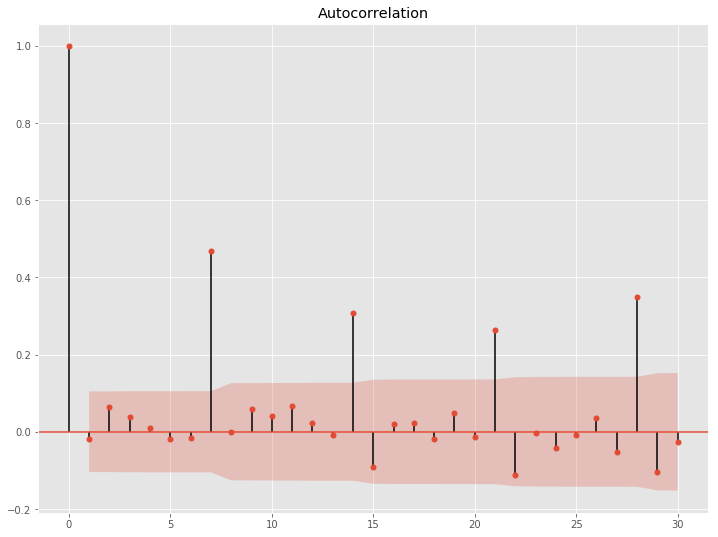

In [5]:
fig, ax = plt.subplots(figsize=(12,9))
plot_acf(df_sales['sales'], lags=30, ax=ax)
plt.show()

**Feature Correlation**

As expected, sales are highly correlated to the number of customers.  Use one but not both in the forecast model.

In [6]:
df_sales.corr()

,is_open,is_holiday,sales,customers
is_open,1.000000,-0.213755,0.495731,0.580738
is_holiday,-0.213755,1.000000,-0.105320,-0.122785
sales,0.495731,-0.105320,1.000000,0.856070
customers,0.580738,-0.122785,0.856070,1.000000


### Load Weather Data

Daily weather data for the store's location pulled from Dark Sky. Record the min & max temps during business hours and also set an 'is_precip' flag if it was raining, snowing or sleeting for much of the business day.

In [7]:
df_wx = pd.read_excel('../data/daily-weather.xlsx')
df_wx.index = pd.to_datetime(df_wx.date)
df_wx.drop('date', axis='columns', inplace=True)
df_wx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 352 entries, 2017-11-17 to 2018-11-03
Data columns (total 3 columns):
min_temp     352 non-null float64
max_temp     352 non-null float64
is_precip    352 non-null int64
dtypes: float64(2), int64(1)
memory usage: 11.0 KB


### Transform a Time Series Problem into Supervised Machine Learning

Time Series forecasting can be re-framed as a supervised learning problem by using data from prior time steps (aka 'Lags') to predict the current target value. The autocorrelation plot above showed spikes at 7, 14, 21 and 28 days so try creating lags for each.

It would also be useful to create a lag of T-1 days but since the project is focused on forecasting a week of data at a time, this is not possible. Imaging generating a forecast for the coming week on a given Sunday. What T-1 day lagged sale value are you going to use for Wednesday? 

In [8]:
# Make lagged features from sales with lags equal to the stongest
# autocorrelation shown above.
y_col = 'sales'
x_cols = ['sales']

# Lags of just 7 and 28 give the best model performance. Try adding
# 14 and 21 to see what happens
lags = [7, 28]

# You can find code for LogTransformer in this Github repo.
trans = LagTransformer(x_cols=x_cols, y_col=y_col, lags=lags)
df_lag = trans.fit_transform(df_in)

# Clean the lagged data to remove the cases where sales from a closed
# day are being used to forecast an open day or vice-versa.
clean = LagCleaner()
df_lag = clean.fit_transform(df_lag)

### Assemble & Clean the Data

In [9]:
# Create non-lagged dummy features for each day
df_day = pd.get_dummies(df_sales.drop(['sales', 'customers'], axis='columns'))

# Combine the day features, lagged data & weather. Note, just include df_wx in the concat
# line below if you want to see what effect weather has on the model. 
df = pd.concat([df_lag, df_day], axis='columns')

df.dropna(inplace=True)

# Trim off the first few rows so we start on a Sunday
start_idx = get_first_sunday(df)
if start_idx > 0:
    df.drop(df.index[:start_idx], inplace=True)
    
df.head(10)

,sales_t-28,sales_t-7,y,is_open,is_holiday,day_fri,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
date,,,,,,,,,,,,
2017-12-17,324.73,518.98,1063.91,1,0,0,0,0,1,0,0,0
2017-12-18,512.08,877.16,509.12,1,0,0,1,0,0,0,0,0
2017-12-19,459.20,298.65,1278.46,1,0,0,0,0,0,0,1,0
2017-12-20,1132.31,533.79,1066.76,1,0,0,0,0,0,0,0,1
2017-12-21,477.41,1743.28,1051.96,1,0,0,0,0,0,1,0,0
2017-12-22,2529.53,972.32,1616.73,1,0,1,0,0,0,0,0,0
2017-12-23,1545.76,1540.67,1238.68,1,0,0,0,1,0,0,0,0
2017-12-24,449.46,1063.91,719.81,1,0,0,0,0,1,0,0,0
2017-12-25,0.00,0.00,0.00,0,1,0,1,0,0,0,0,0


### Time Series Cross Validation

With time series like daily sales or temperature observations, data order matters and must be preserved during model training and testing. The requirement to preserve order between data points rules out using scikit-learn's train_test_split to do the usual k-fold cross validation. The equivalent for time series is back testing through walk forward validation and how it works is explained in the graphic below. 

You can learn lots more __here (https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/)__.

Or read how Facebook Prophet uses this approach as well but in __reverse (https://facebook.github.io/prophet/docs/diagnostics.html)__.

![walk-forward.png](images/walk-forward.png)

Scikit-learn does have a TimeSeriesSplit function to generate train/test splits for time series but it's awkward to use if you want to maintain a fixed-size test interval and have a minimum training set size. So, I wrote my own version called TimeSeriesFixedTestSplit that lets you directly specify a fixed test size and the minimum amount of training data to use. It works just like TimeSeriesSplit and can be used with all of the cross validation and grid search functions in scikit-learn.

The models below are each tested using this approach. Train with a minimum of 16 weeks of data and then test on the next week and increment by a week. For each test interval, calculate Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE). Average over all iterations to get a sense of the model's true performance over the widest range of data possible.

### Start With a Simple Linear Regression Model

In [25]:
model = LinearRegression(normalize=True)

# Do Walk forward validation as described above
df_pred = walk_forward_validate(model, df)
df_m = calc_metrics(df_pred)
weeks = len(df_m.index)

df_m.tail(12)

,MAPE,RMSE
date,,
2018-08-12,23.990701,856.461151
2018-08-19,2.304577,487.363102
2018-08-26,25.261794,620.770862
2018-09-02,13.651052,161.415068
2018-09-09,3.081785,308.810734
2018-09-16,13.343762,290.012762
2018-09-23,6.564109,419.597467
2018-09-30,5.921739,236.804066
2018-10-07,31.515153,300.020208


The above table shows the last 12 weeks of cross validation testing. The model is trained on the prior n-weeks of data and then tested on the week beginning with the date shown above. Each row corresponds to a week starting on the Sunday shown. Looking at the MAPE and RMSE results above shows why cross validation is necessary to get a better sense of model performance. The averaged MAPE and RMSE values over all weeks are shown below.

In [11]:
print('MAPE for {:d} week steps = {:.2f}%'.format(weeks, df_m['MAPE'].mean()))
print('RMSE for {:d} week steps = {:.2f}'.format(weeks, df_m['RMSE'].mean()))

MAPE for 30 week steps = 20.46%
RMSE for 30 week steps = 462.20


### Visualize Predicted vs Actual Sales

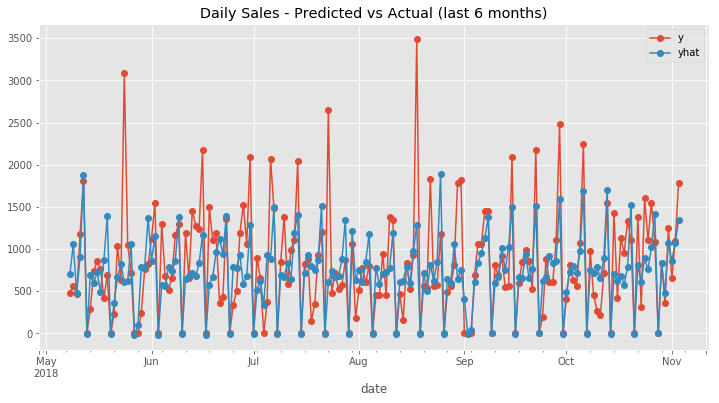

In [12]:
df_fcst = df_pred[['y', 'yhat']][-180:]
df_fcst.plot(figsize=(12, 6), marker='o')
plt.title('Daily Sales - Predicted vs Actual (last 6 months)')
plt.show()

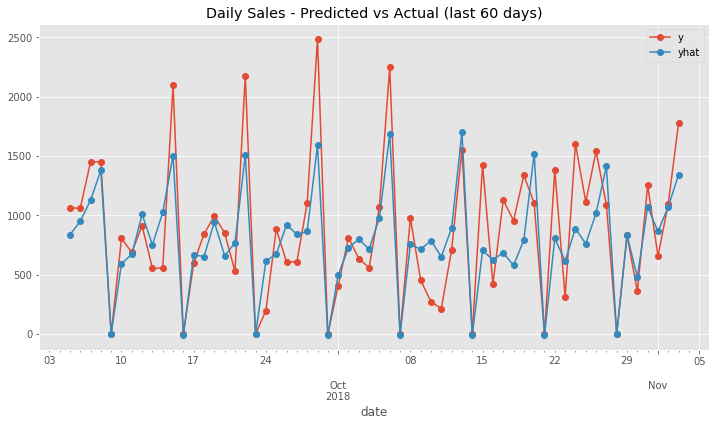

In [13]:
df_latest = df_pred[['y', 'yhat']][-60:]
df_latest.plot(figsize=(12, 6), marker='o')
plt.title('Daily Sales - Predicted vs Actual (last 60 days)')
plt.show()

### Residual Analysis

The residuals should ideally be random, normally distributed with a mean of zero. Not quite the case here but reasonably close. The large, positive spikes below are from days where the business is running a sale. I have yet to find a reasonable way to predict the magnitude of these sale days despite trying Facebook data and other sources.

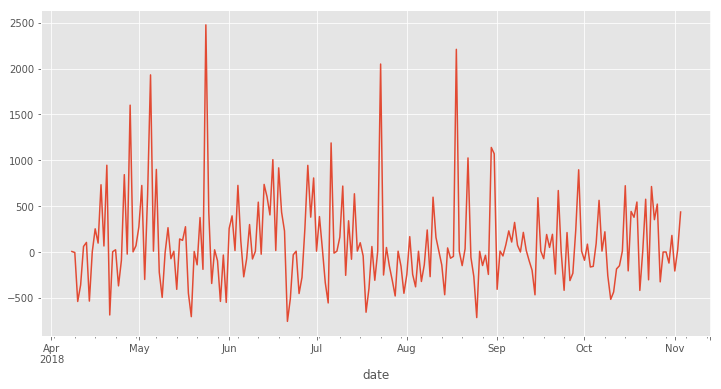

In [14]:
df_resid = df_pred[['error']]

fig, ax = plt.subplots(figsize=(12, 6))
df_resid['error'].plot(ax=ax)
plt.show()

In [15]:
df_resid['error'].describe()

count     210.000000
mean       99.868028
std       495.978829
min      -756.940000
25%      -196.482004
50%         8.866705
75%       256.636088
max      2477.683794
Name: error, dtype: float64

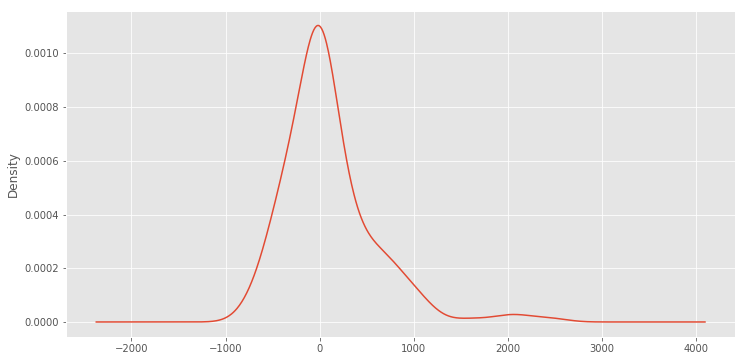

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
df_resid['error'].plot(kind='kde', ax=ax)
plt.show()

### Try Other Linear Models

**Ridge:**

In [17]:
model = Ridge(alpha=0.1, normalize=True)

df_pred = walk_forward_validate(model, df)
df_m = calc_metrics(df_pred)
weeks = len(df_m.index)

print('MAPE for {:d} week steps = {:.2f}%'.format(weeks, df_m['MAPE'].mean()))
print('RMSE for {:d} week steps = {:.2f}'.format(weeks, df_m['RMSE'].mean()))

MAPE for 30 week steps = 20.49%
RMSE for 30 week steps = 460.20


In [18]:
df_m.tail(10)

,MAPE,RMSE
date,,
2018-08-26,23.883712,627.555203
2018-09-02,13.866075,170.999483
2018-09-09,3.370276,307.495104
2018-09-16,13.673542,303.468549
2018-09-23,7.018737,422.678398
2018-09-30,6.174511,254.869861
2018-10-07,28.624397,307.241819
2018-10-14,23.005529,437.944294
2018-10-21,22.249158,457.290951


**Lasso**

In [19]:
model = Lasso(alpha=0.1, normalize=True)

df_pred = walk_forward_validate(model, df)
df_m = calc_metrics(df_pred)
weeks = len(df_m.index)

print('MAPE for {:d} week steps = {:.2f}%'.format(weeks, df_m['MAPE'].mean()))
print('RMSE for {:d} week steps = {:.2f}'.format(weeks, df_m['RMSE'].mean()))

MAPE for 30 week steps = 20.51%
RMSE for 30 week steps = 460.15


In [20]:
df_m.tail(10)

,MAPE,RMSE
date,,
2018-08-26,24.965732,622.133531
2018-09-02,13.866201,163.724639
2018-09-09,3.196010,310.266617
2018-09-16,13.360035,290.985841
2018-09-23,7.011306,412.448524
2018-09-30,5.951239,239.180121
2018-10-07,30.806793,301.671812
2018-10-14,23.127554,442.442915
2018-10-21,21.965954,453.237247


**Elastic Net**

In [21]:
model = ElasticNet()

df_pred = walk_forward_validate(model, df)
df_m = calc_metrics(df_pred)
weeks = len(df_m.index)

print('MAPE for {:d} week steps = {:.2f}%'.format(weeks, df_m['MAPE'].mean()))
print('RMSE for {:d} week steps = {:.2f}'.format(weeks, df_m['RMSE'].mean()))

MAPE for 30 week steps = 20.19%
RMSE for 30 week steps = 474.80


In [22]:
df_m.tail(10)

,MAPE,RMSE
date,,
2018-08-26,24.879473,644.099023
2018-09-02,5.090676,170.753757
2018-09-09,4.016698,288.840717
2018-09-16,11.711621,320.986135
2018-09-23,0.923480,423.446604
2018-09-30,1.071810,240.191745
2018-10-07,30.829378,316.421979
2018-10-14,23.503363,461.906094
2018-10-21,17.614124,425.822882


### Grid Search for Elastic Net

Use the custom splitting function TimeSeriesFixedSplit to do a grid search and pick the best hyper parameters for ElasticNet.

In [23]:
model = ElasticNet()

X = df.drop('y', axis='columns')
y = df[['y']]

# TimeSeriesFixedTestSplit defaults to 16 weeks of training data and one week of test data.
ts_split = TimeSeriesFixedTestSplit(len(X.index))

param_grid = {
    "l1_ratio": [0.01, 0.1, 0.5, 1.0],
    "alpha": [0.1, 1, 10, 100]
}

ts_cv = GridSearchCV(model, param_grid, cv=ts_split, scoring='neg_mean_squared_error')
ts_cv.fit(X, y)
rmse = sqrt(ts_cv.best_score_ * -1.0)

best = ts_cv.best_params_
print('Best params = {}'.format(best))

Best params = {'alpha': 1, 'l1_ratio': 1.0}


In [24]:
model = ElasticNet(**best)

# Repeat walk forward validation with params found through grid search above 
df_pred = walk_forward_validate(model, df)
df_m = calc_metrics(df_pred)
weeks = len(df_m.index)

print('MAPE for {:d} week steps = {:.2f}%'.format(weeks, df_m['MAPE'].mean()))
print('RMSE for {:d} week steps = {:.2f}'.format(weeks, df_m['RMSE'].mean()))

MAPE for 30 week steps = 20.40%
RMSE for 30 week steps = 459.90


### Conclusion - Baseline vs Linear Models

As a recap, here's how the baseline 'How did we do last week?' method scored:

Linear models certainly did better with all coming fairly close to the scores from ElasticNet below.